In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os
import tempfile
from typing import List, Tuple

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.textpath import TextPath
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["font.size"] = 11

import tdgl
from tdgl.geometry import box, ensure_unique, close_curve

SAVE_FIGURES = False
image_path = os.path.join(os.pardir, "images")

## Define the letter geometries

In [2]:
# Letters that have loops will require more than one Polygon to define.
loops_uppercase = "ABDOPQR"
loops_lowercase = "abdegopq"

In [3]:
def interp_path(path: Path, points_per_segment: int = 11) -> np.ndarray:
    """Generate polygon coordinates for a given matplotlib Path"""
    # The paths are defined in terms of Bezier curves, so we need to
    # evaluate the curves at many points.
    t = np.linspace(0, 1, points_per_segment)
    segments = [
        bezier(t) for bezier, code in path.iter_bezier() if code != Path.MOVETO
    ]
    points = np.concatenate(segments)
    return ensure_unique(points)

def make_polygons(
    letter: str,
    fontsize: int,
    fontprops: FontProperties,
    resample_points: Tuple[int, int] = (251, 101),
) -> List[tdgl.Polygon]:
    path = TextPath((0, 0), letter, size=fontsize, prop=fontprops)
    if letter in loops_lowercase + loops_uppercase:
        # If the letter has holes in it, split the overall outline and
        # all holes into separate paths.
        jumps = np.where(path.codes == TextPath.MOVETO)[0][1:]
        vertices = np.split(path.vertices, jumps)
        codes = np.split(path.codes, jumps)
        paths = [Path(v[:-1], c[:-1]) for v, c in zip(vertices, codes)]
    else:
        # If the letter doesn't have holes in it, we only need one path.
        paths = [Path(path.vertices[:-1], path.codes[:-1])]
    polygons = [tdgl.Polygon(points=interp_path(p)) for p in paths]
    # Sort the polygons by area in descending order so that the outline
    # will be first.
    polygons = sorted(polygons, key=lambda p: p.area, reverse=True)
    polygons = (
        [polygons[0].resample(resample_points[0]).buffer(2e-3)]
        + [p.resample(resample_points[1]) for p in polygons[1:]]
    )
    # Name the polygons
    for i, p in enumerate(polygons):
        if i == 0:
            p.name = letter
        else:
            p.name = f"hole{i}"
    return polygons

## Make a `Device` for each letter

In [4]:
fontsize = 10
fontprops = FontProperties(weight="bold")
xi = 0.4
layer = tdgl.Layer(london_lambda=4, coherence_length=xi, thickness=0.1)

In [5]:
p_outer, p_inner  = make_polygons("p", fontsize, fontprops)
y_outer,  = make_polygons("y", fontsize, fontprops)
film = p_outer.union(y_outer.translate(dx=5.75))

device = tdgl.Device("py", layer=layer, film=film, holes=[p_inner])

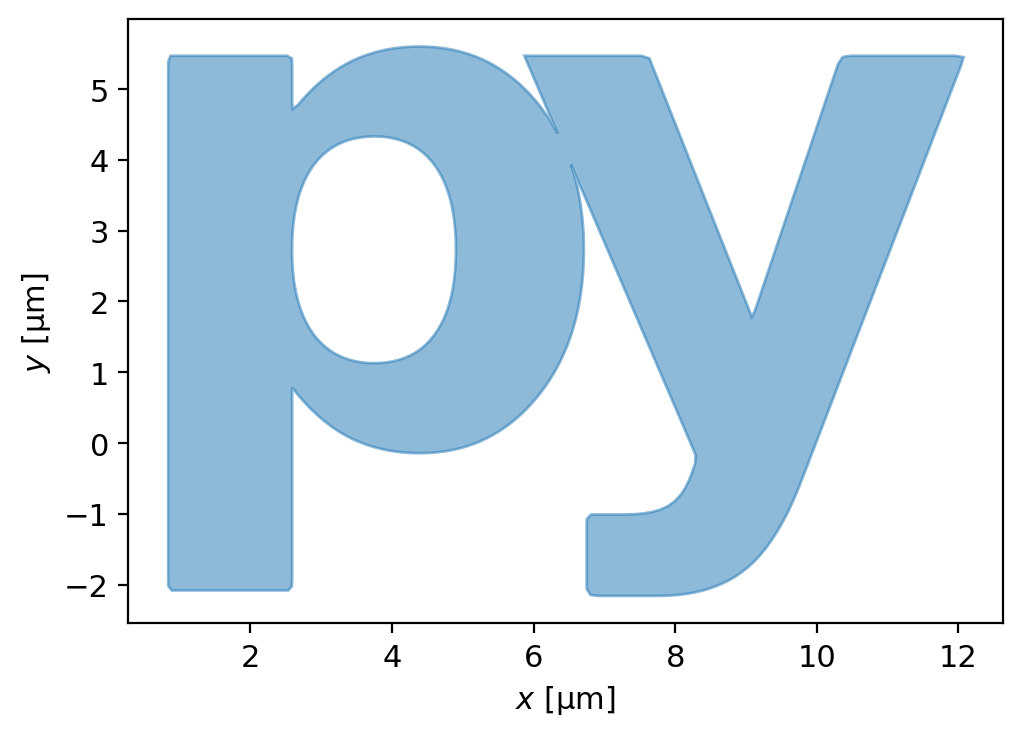

In [6]:
fig, ax = device.draw(legend=False)

## Generate the mesh

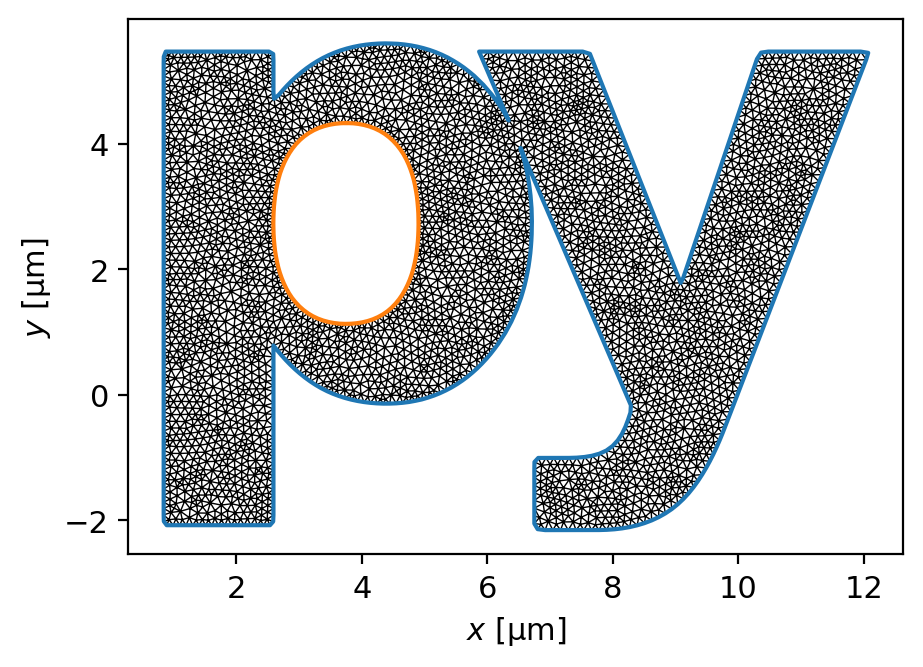

In [7]:
fig, ax = plt.subplots()
device.make_mesh(max_edge_length=xi / 2, smooth=100)
_ = device.plot(ax=ax, mesh=True, legend=False)

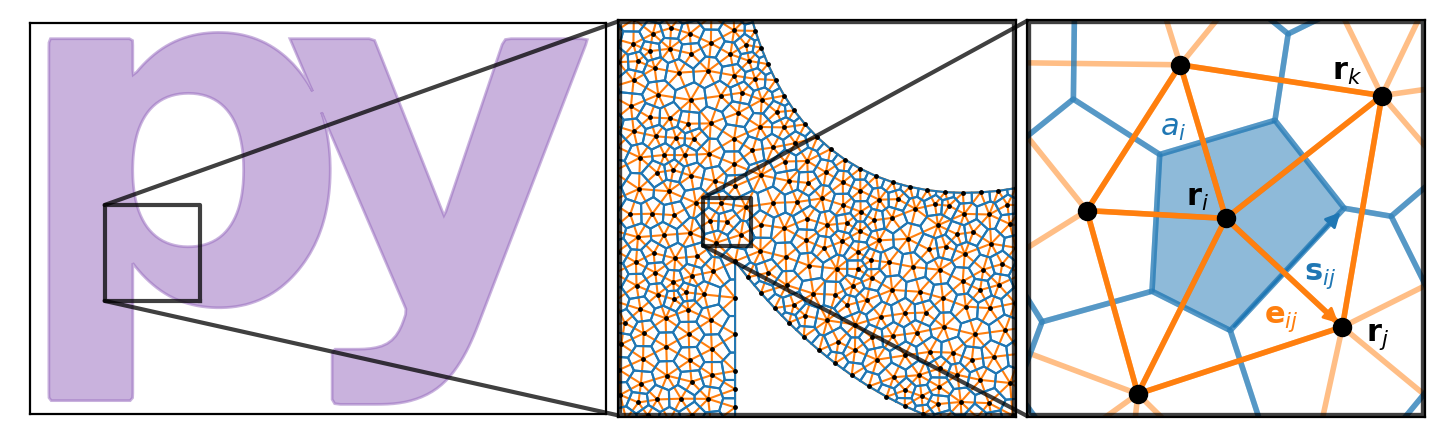

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), gridspec_kw=dict(width_ratios=[1.45, 1, 1]))
ax, bx, cx = axes

mesh = device.mesh

for a in (ax, bx, cx):
    a.set_xticks([])
    a.set_yticks([])
    a.set_aspect("equal")

# Draw the "py" film on the left axes.
scale = 1 / device.coherence_length
patch = device.scale(xfact=scale, yfact=scale).patches()["p"]
patch.set_facecolor("C4")
patch.set_edgecolor("C4")
patch.set_alpha(0.5)
ax.add_artist(patch)
ax.set_xlim(mesh.x.min() - 1, mesh.x.max() + 1)
ax.set_ylim(mesh.y.min() - 0.5, mesh.y.max() + 0.5)

# Plot the mesh on the center and right axes.
for a, lw, marker in [(bx, 0.75, "."), (cx, 2, "o")]:
    _ = mesh.plot(
        ax=a,
        show_sites=False, site_color="k",
        show_edges=True, edge_color="C1",
        show_dual_edges=True, dual_edge_color="C0",
        linewidth=lw,
        marker=marker,
    )
# Zoom in on the relevant parts of the mesh
bx.set_xlim(5, 10)
bx.set_ylim(0, 5)
# Add lines connecting the center and right axes. 
x0, y0, d = 7.5, 2.5, 2.5
bbox = close_curve(box(2 * d, center=(x0, y0)))
kwargs = dict(color="k", alpha=0.75, lw=1.5)
ax.plot(*bbox.T, **kwargs) 
xy1 = np.array([x0 - d, y0 - d])
c1 = mpl.patches.ConnectionPatch(xy1, xy1 + np.array([0, +0.025]), "data", axesA=ax, axesB=bx, **kwargs)
xy2 = np.array([x0 - d, y0 + d])
c2 = mpl.patches.ConnectionPatch(xy2, xy2 + np.array([0, -0.025]), "data", axesA=ax, axesB=bx, **kwargs)
fig.add_artist(c1)
fig.add_artist(c2)
bx.plot(*bbox.T, lw=3, color=kwargs["color"], alpha=kwargs["alpha"])

# Highlight this particular mesh site on the right axes
i0 = mesh.closest_site((6.5, 2.5))
x0, y0 = r0 = mesh.sites[i0]
d = 0.3
cx.set_xlim(x0 - d, x0 + d)
cx.set_ylim(y0 - d, y0 + d)
# Add lines connecting the center and right axes. 
kwargs = dict(color="k", alpha=0.75, lw=1.5)
bbox = close_curve(box(2 * d, center=r0))
bx.plot(*bbox.T, **kwargs) 
xy1 = np.array([x0 - d, y0 - d])
c1 = mpl.patches.ConnectionPatch(xy1, xy1 + np.array([0, +0.002]), "data", axesA=bx, axesB=cx, **kwargs)
xy2 = np.array([x0 - d, y0 + d])
c2 = mpl.patches.ConnectionPatch(xy2, xy2 + np.array([0, -0.002]), "data", axesA=bx, axesB=cx, **kwargs)
fig.add_artist(c1)
fig.add_artist(c2)

# Add a solid patch for the highlighted Voronoi cell
polygon = close_curve(mesh.voronoi_polygons[i0])
path = mpl.path.Path(polygon)
patch = mpl.patches.PathPatch(path, color="C0", alpha=0.5, ec="none")
cx.add_artist(patch)

for line in cx.lines:
    line.set_alpha(0.5)
cx.plot(*bbox.T, lw=3, color=kwargs["color"], alpha=kwargs["alpha"])

# Annotate the right axes with arrows and labels
offsets = [(-0.06, 0.02), (0.035, -0.02), (-0.075, 0.025)]
edges = [(i0, 2387), (2387, 2386), (2386, i0)]
for index, e, ofs in zip("ijk", edges, offsets):
    cx.text(*(mesh.sites[e[0]] + ofs), f"$\\mathbf{{r}}_{{{index}}}$")
    
e = edges[0]
cx.annotate(
    "",
    xy=mesh.sites[e[1]],
    xytext=mesh.sites[e[0]],
    zorder=10,
    arrowprops=dict(ec="C1", fc="C1", arrowstyle="-|>"),
)
r01 = mesh.sites[list(e)].mean(axis=0)
cx.text(*(r01 + (-0.03, -0.075)), "$\\mathbf{e}_{ij}$", color="C1")
cx.text(*(r0 + (-0.1, 0.125)), "$a_i$", color="C0")

s01 = [4179, 7373]
cx.annotate(
    "",
    xy=mesh.dual_sites[s01[1]],
    xytext=mesh.dual_sites[s01[0]],
    zorder=9,
    arrowprops=dict(ec="C0", fc="C0", arrowstyle="-|>"),
)
cx.text(*(mesh.dual_sites[s01].mean(axis=0) + (0.025, -0.015)), "$\\mathbf{s}_{ij}$", color="C0")

bx.plot(mesh.x, mesh.y, "k.", markersize=1.5, zorder=20)
cx.triplot(mesh.x, mesh.y, [tri for tri in mesh.elements if i0 in tri], "C1-", lw=2, zorder=20)
cx.plot(mesh.x, mesh.y, "ko", zorder=21)

fig.subplots_adjust(wspace=0.025)
fig.set_facecolor("white")

if SAVE_FIGURES:
    fig.savefig(os.path.join(image_path, "mesh-py.pdf"), bbox_inches="tight")
    fig.savefig(os.path.join(image_path, "mesh-py.png"), dpi=300, bbox_inches="tight")

In [9]:
tdgl.version_table()

Software,Version
tdgl,0.0.1
Numpy,1.23.3
SciPy,1.9.1
matplotlib,3.6.0
jax,0.3.18
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
BLAS Info,OPENBLAS
